# Discriminibility Code and Testing in Python

### Pseudocode
![image](disc.png)

### Real Code

In [1]:
import numpy as np
import pandas as pd
import collections

def D_partial(eeg_data, subjects, subject, trial1, trial2, dist):
    t1 = eeg_data[subjects == subject][trial1]
    t2 = eeg_data[subjects == subject][trial2]
    d_t1_t2 = dist(t1, t2)
    d_ra = [dist(t1, x) for x in eeg_data[subjects != subject]]
    return np.mean(d_t1_t2 < d_ra)

def D(eeg_data, subjects, dist):
    sra = []
    tra = []
    ttra = []
    mra = []
    partials = []
    for s in np.unique(subjects):
        num = len(eeg_data[subjects == s])
        for t in np.arange(num):
            for tt in np.setdiff1d(np.arange(num), [t]):
                p = D_partial(eeg_data,
                              subjects,
                              s,
                              t,
                              tt,
                              dist)
                partials.append(p)
                sra.append(s)
                tra.append(t)
                ttra.append(tt)
                mra.append(p)
    info = pd.DataFrame(data = np.array([sra, tra, ttra, mra]).T,
                        columns=['Subject',
                                 'Trial',
                                 'Trial_Prime',
                                 'Partial Discriminibility'])         
    return np.mean(partials), info

### Experiment 1 design
We will use the following data and metric

In [2]:
d = np.array([[1], [2], [1], [1]])
subjects = np.array(['A', 'A', 'B', 'B'])
df = pd.DataFrame(data = d, index = subjects)
df.index.name = 'Subject'
df.columns = ['Value']
print 'Experiment 1 Data'
df

Experiment 1 Data


,Value
Subject,
A,1
A,2
B,1
B,1


Simple experiment metric:
$
\delta(x, y) = \vert x - y \vert
$

Expected answer is 0.25.

### Experiment 2 design

In [3]:
disc, info = D(d, subjects, lambda x, y: np.abs(x[0] - y[0]))
print disc
info

0.25


,Subject,Trial,Trial_Prime,Partial Discriminibility
0,A,0,1,0.0
1,A,1,0,0.0
2,B,0,1,0.5
3,B,1,0,0.5


### Experiment 2 Design
We will place points on a plane as follows:

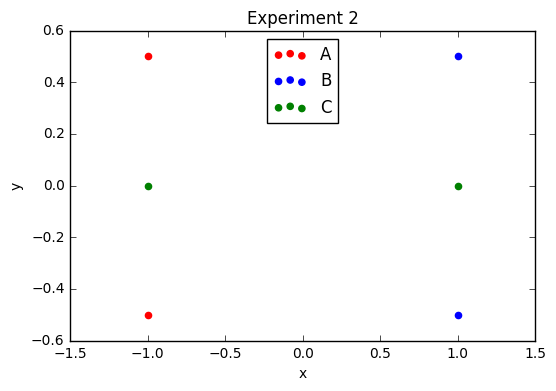

In [4]:
import matplotlib.pyplot as plt
d = np.array([[-1, .5], [-1, -.5], [1, .5], [1, -.5], [-1, 0], [1, 0]])
subjects = np.array(['A', 'A', 'B', 'B', 'C', 'C'])
plt.scatter(d[subjects == 'A'][:, 0], d[subjects == 'A'][:, 1], color = 'red', label = 'A')
plt.scatter(d[subjects == 'B'][:, 0], d[subjects == 'B'][:, 1], color = 'blue', label = 'B')
plt.scatter(d[subjects == 'C'][:, 0], d[subjects == 'C'][:, 1], color = 'green', label = 'C')
plt.xlabel("x")
plt.ylabel("y")
plt.title('Experiment 2')
plt.legend(loc='upper center')
plt.show()

The metric we will use is the $l_2$ norm e.g. $\delta(\vec{x}, \vec{y}) = \vert\vert \vec{x} - \vec{y} \vert\vert_{2}^{2}$

We expect the answer to be $\frac{2}{3}$

### Experiment 2 Test

In [5]:
disc, info = D(d, subjects, lambda x, y: np.linalg.norm(x - y))
print disc

0.666666666667


### Experiment 3 Design

In [6]:
import seaborn as sns
n = 1000
d = np.hstack([np.random.uniform(0, 2, n), np.random.uniform(1, 3, n)])
subjects = np.array(['A'] * n + ['B'] * n)
df = pd.DataFrame.from_dict({'Trial': d, 'Subject': subjects})

eg., we take n samples of a random variable $A \sim uni(0, 2)$ and n of a random variable $B \sim uni(1, 3)$.

We can figure out what the true answer should be using monte carlo with the samples $A \sim uni(0, 2), B \sim uni(0, 2), C \sim uni(1, 3)$
We can use monte carlo to figure out what should be $P(\vert A - B \vert < \vert A - C \vert$

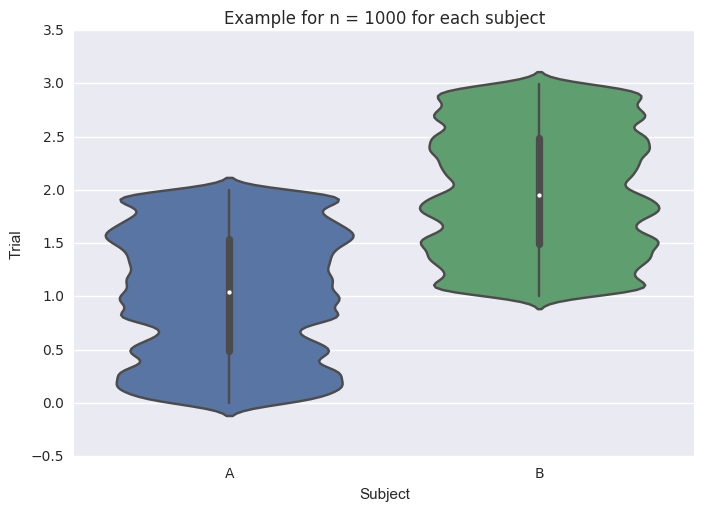

Answer should be:  0.677021


In [7]:
sns.violinplot(x = 'Subject', y = 'Trial', data = df, split = True, bw = .1)
plt.title("Example for n = 1000 for each subject")
plt.show()
print 'Answer should be: ',
a = np.random.uniform(0, 2, 1000000)
b = np.random.uniform(0, 2, 1000000)
c = np.random.uniform(1, 3, 1000000)
ans = np.mean(np.abs(a - b) < np.abs(a - c))
print ans

### Experiment 3 test - 300 experiments of 2 subjects with 30 trials

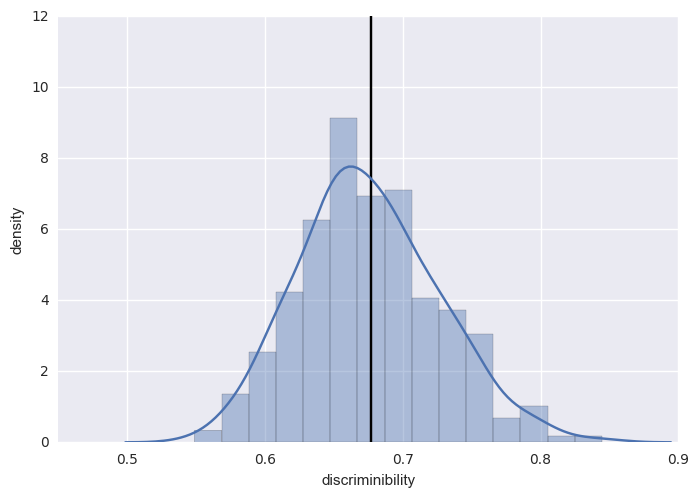

CPU times: user 1min 8s, sys: 24 ms, total: 1min 8s
Wall time: 1min 8s


In [8]:
%%time
n = 30
results = []
for i in range(300):
    d = np.hstack([np.random.uniform(0, 2, n), np.random.uniform(1, 3, n)])
    subjects = np.array(['A'] * n + ['B'] * n)
    disc, info = D(d, subjects, lambda x, y: np.linalg.norm(x - y))
    results.append(disc)
sns.distplot(results)
plt.vlines(ans, 0, 12)
plt.xlabel('discriminibility')
plt.ylabel('density')
plt.show()

### Complexity
The above implementation should be $O(S^2T^3)$ where $S$ is the number of subjects and $T$ is the number of trials.
It is quite clear that a dynamic programming solution exists for this problem, which should dramatically reduce the running time.